# Deep Q-Network (DQN)

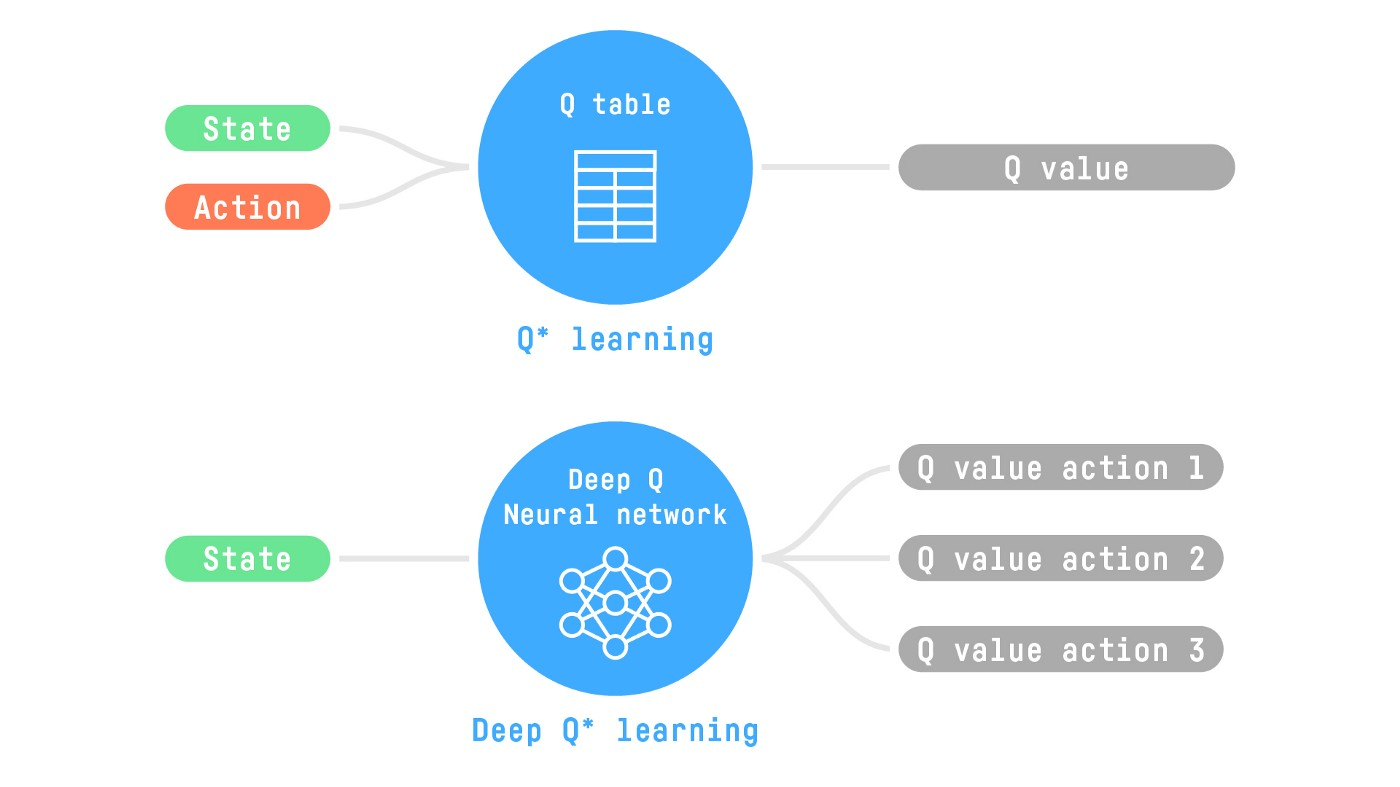

**Courtesy:** https://huggingface.co/learn/deep-rl-course/en/unit3/from-q-to-dqn


<br><br>

---

**Achieves super-human performance on Atari games.**

Watch the video here: https://www.youtube.com/watch?v=TmPfTpjtdgg

---

<br><br>



<br><br>
## Now, let us train to balance the pole using DQN algorithm.
<br><br>

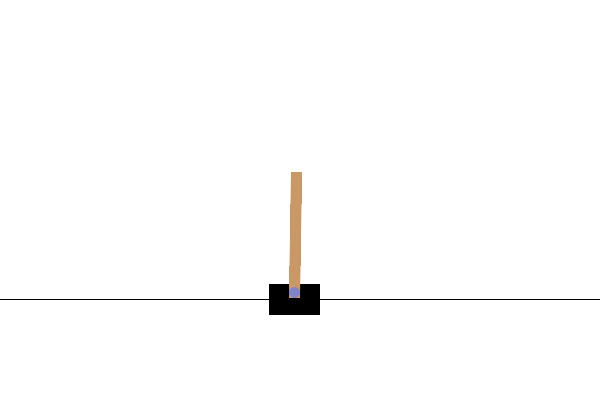

In [ ]:
# Installing the required packages

!pip -q install --upgrade pip
!pip -q install gymnasium==1.2.0 stable_baselines3==2.7.0

In [ ]:
# Fetching the eval script

!wget -q https://raw.githubusercontent.com/EshwarSR/RPI-ClassicControl/refs/heads/main/Cartpole/custom_eval.py

In [ ]:
# Importing all the required packages

import gymnasium as gym
import matplotlib.pyplot as plt
import re
from matplotlib.lines import Line2D
import os
import numpy as np

from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import SubprocVecEnv

from typing import Callable
from wandb.integration.sb3 import WandbCallback
from stable_baselines3.common.callbacks import CallbackList

from custom_eval import EvalWithCriticCallback
import time
import datetime

# --- Plotting Style & Aesthetics ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.size": 15,
    "axes.labelsize": 18,
    "axes.titlesize": 15,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 16,
    "figure.titlesize": 14
})

# --- Colors for the algorithms ---
ALGO_COLORS = {
    'DQN': '#D95F02',      # orange
    'RPI': '#1B9E77',      # green
}

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# DQN on Cartpole - 2 layers of 256 neurons each

In [ ]:
##########################################
# DQN/RPI hyperparameters (from SB3 zoo) #
##########################################
# https://github.com/DLR-RM/rl-baselines3-zoo/blob/ab4aadb57c6c42abcf1016318c2bebe35c4c1270/hyperparams/dqn.yml#L20

hyperparams = {
    'policy': 'MlpPolicy',
    'learning_rate': 2.3e-3,
    'batch_size': 64,
    'buffer_size': 100000,
    'learning_starts': 1000,
    'gamma': 0.99,
    'target_update_interval': 10,
    'train_freq': 256,
    'gradient_steps': 128,
    'exploration_fraction': 0.16,
    'exploration_final_eps': 0.04,
    'policy_kwargs': dict(net_arch=[256, 256]),
    'verbose': 0,
    'seed': 0,
    'device': "cpu"
}

##############
# Parameters #
##############

n_timesteps = 50_000
eval_freq = 5000
n_eval_episodes = 5


######################
# Setup environments #
######################

def make_env():
    env = gym.make("CartPole-v1")
    return Monitor(env)

n_envs = 1
env = DummyVecEnv([make_env])
eval_env = DummyVecEnv([make_env])

env.seed(hyperparams["seed"])
eval_env.seed(hyperparams["seed"])


############
# Training #
############

model = DQN(env=env, **hyperparams)
folder_path = "./results/net-arch/DQN/width_256_depth_2/seed_0"

# Setup evaluation callback
eval_callback = EvalWithCriticCallback(
    eval_env=eval_env,
    eval_freq=eval_freq,
    n_eval_episodes=n_eval_episodes,
    save_path=folder_path,
    algo="DQN",
    verbose=1,
    gamma=hyperparams['gamma']
)
callback_list = eval_callback
# Train the model
print("Starting training...")
tic = time.time()
model.learn(total_timesteps=n_timesteps, callback=callback_list)
toc = time.time()
print(f"\nTraining complete!\nTime taken to run: {datetime.timedelta(seconds=int(toc-tic))}\nResults saved to: {folder_path}")

Starting training...
Eval num_timesteps=5000, episode_reward=163.80 +/- 6.18
Episode length: 163.80 +/- 6.18
New best mean reward!
[Eval] Timesteps: 5000 Avg Disc Return: 82.25, Avg V(s_0): 15.9083
Eval num_timesteps=10000, episode_reward=247.00 +/- 127.93
Episode length: 247.00 +/- 127.93
New best mean reward!
[Eval] Timesteps: 10000 Avg Disc Return: 85.92, Avg V(s_0): 33.0997
Eval num_timesteps=15000, episode_reward=91.20 +/- 1.72
Episode length: 91.20 +/- 1.72
[Eval] Timesteps: 15000 Avg Disc Return: 60.25, Avg V(s_0): 46.0507
Eval num_timesteps=20000, episode_reward=47.20 +/- 33.74
Episode length: 47.20 +/- 33.74
[Eval] Timesteps: 20000 Avg Disc Return: 42.58, Avg V(s_0): 57.8532
Eval num_timesteps=25000, episode_reward=104.20 +/- 1.17
Episode length: 104.20 +/- 1.17
[Eval] Timesteps: 25000 Avg Disc Return: 64.97, Avg V(s_0): 67.9622
Eval num_timesteps=30000, episode_reward=354.00 +/- 8.99
Episode length: 354.00 +/- 8.99
New best mean reward!
[Eval] Timesteps: 30000 Avg Disc Return

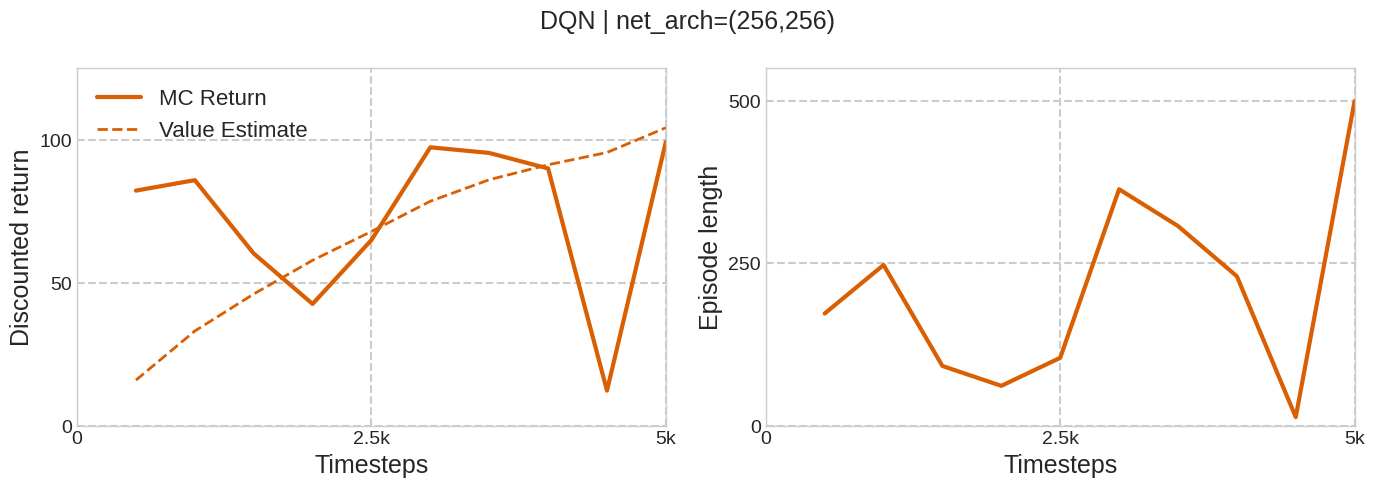

In [ ]:
algo = "DQN"
width= 256
color = ALGO_COLORS[algo]
folder_path = f"./results/net-arch/{algo}/width_{width}_depth_2/seed_0"

true_return = np.load(folder_path + '/mc_disc_returns.npy', allow_pickle=True).mean(axis=1)
est_values  = np.load(folder_path + '/v_s0_estimates.npy', allow_pickle=True).mean(axis=1)
eps_lengths = np.load(folder_path + '/episode_durations.npy', allow_pickle=True).mean(axis=1)
eval_timesteps = np.load(folder_path + '/time_steps_of_eval.npy', allow_pickle=True).mean(axis=1)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

# ---------------- Left plot: Return vs Value ----------------
ax = axes[0]
ax.plot(eval_timesteps, true_return,
        color=color, linestyle='-', linewidth=3, label=f'MC Return')
ax.plot(eval_timesteps, est_values,
        color=color, linestyle='--', linewidth=2, label=f'Value Estimate')


ax.set_ylim(0, 125)
ax.set_xlim(0, 50000)
ax.set_xticks([0, 25000, 50000])
ax.set_xticklabels(['0', '2.5k', '5k'])
ax.set_yticks([0, 50, 100])
ax.set_ylabel("Discounted return")
ax.set_xlabel("Timesteps")
ax.grid(True, which='both', linestyle='--', linewidth=1.5)
ax.legend()

# ---------------- Right plot: Episode length ----------------
ax = axes[1]
ax.plot(eval_timesteps, eps_lengths,
        color=color, linestyle='-', linewidth=3, label=f'{algo}')

ax.set_ylim(0, 550)
ax.set_xlim(0, 50000)
ax.set_xticks([0, 25000, 50000])
ax.set_xticklabels(['0', '2.5k', '5k'])
ax.set_yticks([0, 250, 500])
ax.set_ylabel("Episode length")
ax.set_xlabel("Timesteps")
ax.grid(True, which='both', linestyle='--', linewidth=1.5)


fig.suptitle(f"{algo} | net_arch=({width},{width})", fontsize=18)
plt.tight_layout()
plt.show()


# Issues with DQN

- Theory is for tabular setting. Works well when the function approximation class is *rich enough*.
- Overestimation.
- Can oscillate or even suffer performance degradation.

# DQN on Cartpole - 2 layers of 8 neurons each

In [ ]:
############
# Training #
############

hyperparams8 = hyperparams.copy()
hyperparams8['policy_kwargs'] = dict(net_arch=[8, 8])

folder_path = "./results/net-arch/DQN/width_8_depth_2/seed_0"
model = DQN(env=env, **hyperparams8)

# Setup evaluation callback
eval_callback = EvalWithCriticCallback(
    eval_env=eval_env,
    eval_freq=eval_freq,
    n_eval_episodes=n_eval_episodes,
    save_path=folder_path,
    algo="DQN",
    verbose=1,
    gamma=hyperparams['gamma']
)
callback_list = eval_callback
# Train the model
print("Starting training...")
tic = time.time()
model.learn(total_timesteps=n_timesteps, callback=callback_list)
toc = time.time()
print(f"\nTraining complete!\nTime taken to run: {datetime.timedelta(seconds=int(toc-tic))}\nResults saved to: {folder_path}")



Starting training...
Eval num_timesteps=5000, episode_reward=105.80 +/- 32.73
Episode length: 105.80 +/- 32.73
New best mean reward!
[Eval] Timesteps: 5000 Avg Disc Return: 59.08, Avg V(s_0): 15.0283
Eval num_timesteps=10000, episode_reward=117.80 +/- 7.98
Episode length: 117.80 +/- 7.98
New best mean reward!
[Eval] Timesteps: 10000 Avg Disc Return: 68.70, Avg V(s_0): 31.5615
Eval num_timesteps=15000, episode_reward=63.40 +/- 3.72
Episode length: 63.40 +/- 3.72
[Eval] Timesteps: 15000 Avg Disc Return: 46.37, Avg V(s_0): 46.2195
Eval num_timesteps=20000, episode_reward=9.60 +/- 0.80
Episode length: 9.60 +/- 0.80
[Eval] Timesteps: 20000 Avg Disc Return: 8.83, Avg V(s_0): 57.7159
Eval num_timesteps=25000, episode_reward=8.80 +/- 0.75
Episode length: 8.80 +/- 0.75
[Eval] Timesteps: 25000 Avg Disc Return: 8.83, Avg V(s_0): 73.7047
Eval num_timesteps=30000, episode_reward=9.20 +/- 0.40
Episode length: 9.20 +/- 0.40
[Eval] Timesteps: 30000 Avg Disc Return: 9.01, Avg V(s_0): 109.1325
Eval num_

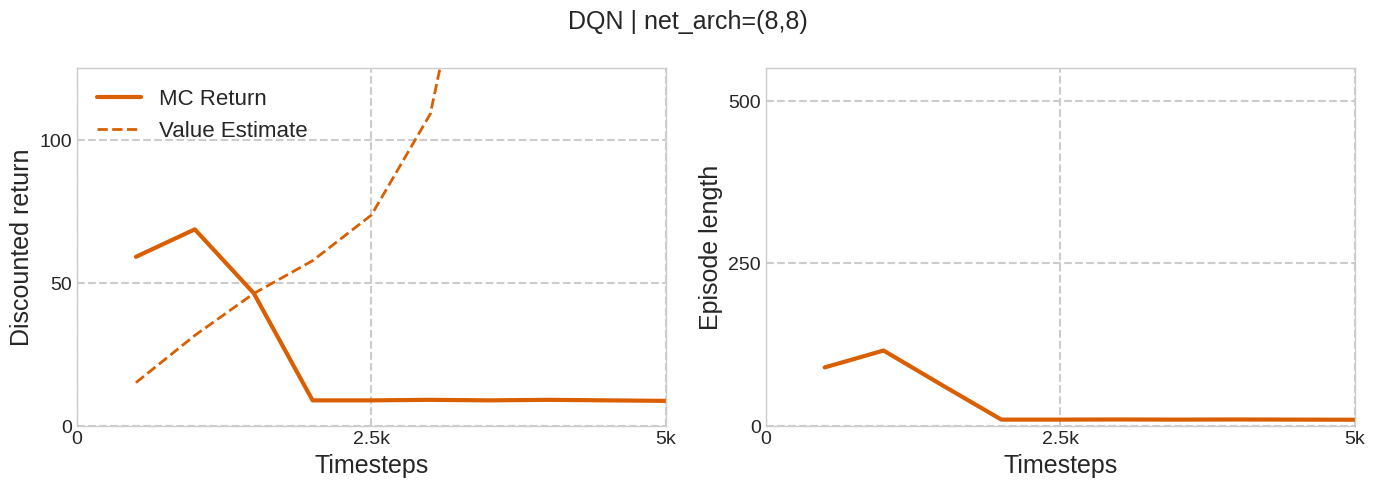

In [ ]:
algo = "DQN"
width= 8
color = ALGO_COLORS[algo]
folder_path = f"./results/net-arch/{algo}/width_{width}_depth_2/seed_0"

true_return = np.load(folder_path + '/mc_disc_returns.npy', allow_pickle=True).mean(axis=1)
est_values  = np.load(folder_path + '/v_s0_estimates.npy', allow_pickle=True).mean(axis=1)
eps_lengths = np.load(folder_path + '/episode_durations.npy', allow_pickle=True).mean(axis=1)
eval_timesteps = np.load(folder_path + '/time_steps_of_eval.npy', allow_pickle=True).mean(axis=1)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

# ---------------- Left plot: Return vs Value ----------------
ax = axes[0]
ax.plot(eval_timesteps, true_return,
        color=color, linestyle='-', linewidth=3, label=f'MC Return')
ax.plot(eval_timesteps, est_values,
        color=color, linestyle='--', linewidth=2, label=f'Value Estimate')


ax.set_ylim(0, 125)
ax.set_xlim(0, 50000)
ax.set_xticks([0, 25000, 50000])
ax.set_xticklabels(['0', '2.5k', '5k'])
ax.set_yticks([0, 50, 100])
ax.set_ylabel("Discounted return")
ax.set_xlabel("Timesteps")
ax.grid(True, which='both', linestyle='--', linewidth=1.5)
ax.legend()

# ---------------- Right plot: Episode length ----------------
ax = axes[1]
ax.plot(eval_timesteps, eps_lengths,
        color=color, linestyle='-', linewidth=3, label=f'{algo}')

ax.set_ylim(0, 550)
ax.set_xlim(0, 50000)
ax.set_xticks([0, 25000, 50000])
ax.set_xticklabels(['0', '2.5k', '5k'])
ax.set_yticks([0, 250, 500])
ax.set_ylabel("Episode length")
ax.set_xlabel("Timesteps")
ax.grid(True, which='both', linestyle='--', linewidth=1.5)


fig.suptitle(f"{algo} | net_arch=({width},{width})", fontsize=18)
plt.tight_layout()
plt.show()


# We propose RPI (Reliable Policy Iteration) designed for function approximation.

.

# Recall: Classical Policy Iteration (Howard, '60)

- Initialize a policy $\mu_0$
- For $k = 0,1,2,\dots$
    - **Policy Evaluation:** Compute the exact action--value function
        $$Q_{\mu_k} = T_{\mu_k} Q_{\mu_k}$$
    - **Policy Improvement:** Update the policy greedily
        $$\mu_{k+1} \in \text{Greedy}(Q_{\mu_k})$$
    - Terminate when the Q-value stops changing


</br>

## Guarantees

**Monotonic Improvement**
    $$Q_{\mu_0} \le Q_{\mu_1} \le Q_{\mu_2} \le \dots$$

**Finite Convergence**
    $$Q_{\mu_k} \to Q^* \quad \text{in finitely many iterations} $$

---

<br><br>

# Proposed Method: RPI

**Key Idea:** Reformulate policy evaluation as Bellman-constrained optimization.


- Initialize policy $\mu_0$ and value estimate $f_0 \in {F}$
- For $k = 0,1,2,\dots$
        
    - **Policy Evaluation:**
        $$
        f_{k+1} \in \arg\max_{f \in {F}} ||f - f_k||
        \quad \text{s.t.} \quad
        T_{\mu_k} f \ge f \ge f_k
        $$
    - **Policy Improvement:**
        $$
        \mu_{k+1} \in \text{Greedy}(f_{k+1})
        $$

## Guarantees


**Generalizes PI:** RPI matches PI under tabular setting


For *arbitrary function classes*, assuming $T_{\mu_0}f_0 \geq f_0$:
- **Feasibility:** Optimization problem remains feasible at all iterations
    
- **Monotonicity:**
    $$
    f_0 \le f_1 \le f_2 \le \dots \qquad \text{and} \qquad f_k \leq Q_{\mu_k}
     \quad \forall k$$

---

<br><br>

## Model-free extension


**Goal:** Approximate the Bellman-constrained evaluation
    $f_{k+1} = \arg\max_f ||f-f_k|| \text{ s.t. } T_{\mu_k} f \ge f \ge f_k$
    using samples.

**Challenges:**
- Constraints per $(s,a)$ pair
- Cannot compute $T_{\mu_k}$, since we do not have access to transition matrix $P$
  
**Approach:**
    
- Convert the constrained optimization problem into unconstrained objective using penalty based method
- Use samples to run stochastic gradient descent on the new unconstrained optimization problem



$$
{L}_{\text{RPI}}(f)
= \frac{1}{|{B}|} \sum_{i=1}^{|{B}|}
\Big(
- c\, f(s_i,a_i)
+ \lambda_1 [ f(s_i,a_i) - y_i ]_+
+ \lambda_2 [ q_{\min} - f(s_i,a_i) ]_+
\Big)
$$


- $[x]_+ = \max(x,0)$
- $y_i \approx T_\mu f(s_i,a_i) = r_i + \gamma f(s'_i,a'_i)$ (target network).
- **Role of each term:**
    - $-c\,f$: encourages monotone value improvement
    - $[f - y_i]\_+$: penalizes violation of $f \le T_\mu f$
    - $[q_{\min} - f]_+$: enforces a lower bound ($f \ge f_k$)

---

<br><br>

# RPI - Code

.

In [ ]:
# The file contents is taken from https://github.com/DLR-RM/stable-baselines3/blob/master/stable_baselines3/dqn/dqn.py

import warnings
from typing import  Any, ClassVar, Optional, TypeVar, Union

import wandb
import numpy as np
import torch as th
from gymnasium import spaces
from torch.nn import functional as F
import torch

from stable_baselines3.common.buffers import ReplayBuffer
from stable_baselines3.common.off_policy_algorithm import OffPolicyAlgorithm
from stable_baselines3.common.policies import BasePolicy
from stable_baselines3.common.type_aliases import GymEnv, MaybeCallback, Schedule
from stable_baselines3.common.utils import get_linear_fn, get_parameters_by_name, polyak_update
from stable_baselines3.dqn.policies import CnnPolicy, DQNPolicy, MlpPolicy, MultiInputPolicy, QNetwork

SelfRPI = TypeVar("SelfRPI", bound="RPI")


class RPI_DQN(OffPolicyAlgorithm):
    """
    RPI Deep Q-Network (RPI_DQN)

    Paper: https://arxiv.org/abs/1312.5602, https://www.nature.com/articles/nature14236
    Default hyperparameters are taken from the Nature paper,
    except for the optimizer and learning rate that were taken from Stable Baselines defaults.

    :param policy: The policy model to use (MlpPolicy, CnnPolicy, ...)
    :param env: The environment to learn from (if registered in Gym, can be str)
    :param learning_rate: The learning rate, it can be a function
        of the current progress remaining (from 1 to 0)
    :param buffer_size: size of the replay buffer
    :param learning_starts: how many steps of the model to collect transitions for before learning starts
    :param batch_size: Minibatch size for each gradient update
    :param tau: the soft update coefficient ("Polyak update", between 0 and 1) default 1 for hard update
    :param gamma: the discount factor
    :param train_freq: Update the model every ``train_freq`` steps. Alternatively pass a tuple of frequency and unit
        like ``(5, "step")`` or ``(2, "episode")``.
    :param gradient_steps: How many gradient steps to do after each rollout (see ``train_freq``)
        Set to ``-1`` means to do as many gradient steps as steps done in the environment
        during the rollout.
    :param replay_buffer_class: Replay buffer class to use (for instance ``HerReplayBuffer``).
        If ``None``, it will be automatically selected.
    :param replay_buffer_kwargs: Keyword arguments to pass to the replay buffer on creation.
    :param optimize_memory_usage: Enable a memory efficient variant of the replay buffer
        at a cost of more complexity.
        See https://github.com/DLR-RM/stable-baselines3/issues/37#issuecomment-637501195
    :param target_update_interval: update the target network every ``target_update_interval``
        environment steps.
    :param exploration_fraction: fraction of entire training period over which the exploration rate is reduced
    :param exploration_initial_eps: initial value of random action probability
    :param exploration_final_eps: final value of random action probability
    :param max_grad_norm: The maximum value for the gradient clipping
    :param stats_window_size: Window size for the rollout logging, specifying the number of episodes to average
        the reported success rate, mean episode length, and mean reward over
    :param tensorboard_log: the log location for tensorboard (if None, no logging)
    :param policy_kwargs: additional arguments to be passed to the policy on creation. See :ref:`dqn_policies`
    :param verbose: Verbosity level: 0 for no output, 1 for info messages (such as device or wrappers used), 2 for
        debug messages
    :param seed: Seed for the pseudo random generators
    :param device: Device (cpu, cuda, ...) on which the code should be run.
        Setting it to auto, the code will be run on the GPU if possible.
    :param _init_setup_model: Whether or not to build the network at the creation of the instance
    """

    policy_aliases: ClassVar[dict[str, type[BasePolicy]]] = {
        "MlpPolicy": MlpPolicy,
        "CnnPolicy": CnnPolicy,
        "MultiInputPolicy": MultiInputPolicy,
    }
    # Linear schedule will be defined in `_setup_model()`
    exploration_schedule: Schedule
    q_net: QNetwork
    q_net_target: QNetwork
    policy: DQNPolicy

    def __init__(
        self,
        policy: Union[str, type[DQNPolicy]],
        env: Union[GymEnv, str],
        learning_rate: Union[float, Schedule] = 1e-4,
        buffer_size: int = 1_000_000,  # 1e6
        learning_starts: int = 100,
        batch_size: int = 32,
        tau: float = 1.0,
        gamma: float = 0.99,
        train_freq: Union[int, tuple[int, str]] = 4,
        gradient_steps: int = 1,
        replay_buffer_class: Optional[type[ReplayBuffer]] = None,
        replay_buffer_kwargs: Optional[dict[str, Any]] = None,
        optimize_memory_usage: bool = False,
        target_update_interval: int = 10000,
        exploration_fraction: float = 0.1,
        exploration_initial_eps: float = 1.0,
        exploration_final_eps: float = 0.05,
        max_grad_norm: float = 10,
        stats_window_size: int = 100,
        tensorboard_log: Optional[str] = None,
        policy_kwargs: Optional[dict[str, Any]] = None,
        verbose: int = 0,
        seed: Optional[int] = None,
        device: Union[th.device, str] = "auto",
        _init_setup_model: bool = True,

        my_c: float = 1.0,
        my_lambda1: float = 10.0,
        my_lambda2: float = 2.0,
        my_r_min: float = 1.0,

        use_wandb: bool = False,
    ) -> None:
        super().__init__(
            policy,
            env,
            learning_rate,
            buffer_size,
            learning_starts,
            batch_size,
            tau,
            gamma,
            train_freq,
            gradient_steps,
            action_noise=None,  # No action noise
            replay_buffer_class=replay_buffer_class,
            replay_buffer_kwargs=replay_buffer_kwargs,
            policy_kwargs=policy_kwargs,
            stats_window_size=stats_window_size,
            tensorboard_log=tensorboard_log,
            verbose=verbose,
            device=device,
            seed=seed,
            sde_support=False,
            optimize_memory_usage=optimize_memory_usage,
            supported_action_spaces=(spaces.Discrete,),
            support_multi_env=True,
        )

        self.exploration_initial_eps = exploration_initial_eps
        self.exploration_final_eps = exploration_final_eps
        self.exploration_fraction = exploration_fraction
        self.target_update_interval = target_update_interval
        # For updating the target network with multiple envs:
        self._n_calls = 0
        self.max_grad_norm = max_grad_norm
        # "epsilon" for the epsilon-greedy exploration
        self.exploration_rate = 0.0

        if _init_setup_model:
            self._setup_model()

        self.my_c = my_c
        self.my_lambda1 = my_lambda1
        self.my_lambda2 = my_lambda2
        self.my_r_min = my_r_min

    def _setup_model(self) -> None:
        super()._setup_model()
        self._create_aliases()
        # Copy running stats, see GH issue #996
        self.batch_norm_stats = get_parameters_by_name(self.q_net, ["running_"])
        self.batch_norm_stats_target = get_parameters_by_name(self.q_net_target, ["running_"])
        self.exploration_schedule = get_linear_fn(
            self.exploration_initial_eps,
            self.exploration_final_eps,
            self.exploration_fraction,
        )

        if self.n_envs > 1:
            if self.n_envs > self.target_update_interval:
                warnings.warn(
                    "The number of environments used is greater than the target network "
                    f"update interval ({self.n_envs} > {self.target_update_interval}), "
                    "therefore the target network will be updated after each call to env.step() "
                    f"which corresponds to {self.n_envs} steps."
                )

    def _create_aliases(self) -> None:
        self.q_net = self.policy.q_net
        self.q_net_target = self.policy.q_net_target

    def _on_step(self) -> None:
        """
        Update the exploration rate and target network if needed.
        This method is called in ``collect_rollouts()`` after each step in the environment.
        """
        self._n_calls += 1
        # Account for multiple environments
        # each call to step() corresponds to n_envs transitions
        if self._n_calls % max(self.target_update_interval // self.n_envs, 1) == 0:
            polyak_update(self.q_net.parameters(), self.q_net_target.parameters(), self.tau)
            # Copy running stats, see GH issue #996
            polyak_update(self.batch_norm_stats, self.batch_norm_stats_target, 1.0)

        self.exploration_rate = self.exploration_schedule(self._current_progress_remaining)
        self.logger.record("rollout/exploration_rate", self.exploration_rate)

    def train(self, gradient_steps: int, batch_size: int = 100) -> None:
        # Switch to train mode (this affects batch norm / dropout)
        self.policy.set_training_mode(True)
        # Update learning rate according to schedule
        self._update_learning_rate(self.policy.optimizer)

        losses = []
        for _ in range(gradient_steps):
            # Sample replay buffer
            replay_data = self.replay_buffer.sample(batch_size, env=self._vec_normalize_env)  # type: ignore[union-attr]

            with th.no_grad():
                # Compute the next Q-values using the target network
                next_q_values = self.q_net_target(replay_data.next_observations)
                # Follow greedy policy: use the one with the highest value
                next_q_values, _ = next_q_values.max(dim=1)
                # Avoid potential broadcast issue
                next_q_values = next_q_values.reshape(-1, 1)
                # 1-step TD target
                target_q_values = replay_data.rewards + (1 - replay_data.dones) * self.gamma * next_q_values

            # Get current Q-values estimates
            current_q_values = self.q_net(replay_data.observations)

            # Retrieve the q-values for the actions from the replay buffer
            current_q_values = th.gather(current_q_values, dim=1, index=replay_data.actions.long())

            # Default DQN Loss
            # # Compute Huber loss (less sensitive to outliers)
            # loss = F.smooth_l1_loss(current_q_values, target_q_values)

            # RPI Loss with configurable penalty function
            # Term 1: -c * Q(s,a)
            term1 = -self.my_c * current_q_values

            # Compute TD error and r_min difference
            td_error = current_q_values - target_q_values
            r_min_diff = self.my_r_min - current_q_values

            lambda_coeffs = self.my_lambda1

            term2 = lambda_coeffs * F.relu(td_error)
            term3 = self.my_lambda2 * F.relu(r_min_diff)

            # Total loss
            loss = torch.mean(term1 + term2 + term3)
            losses.append(loss.item())

            # Optimize the policy
            self.policy.optimizer.zero_grad()
            loss.backward()
            # Clip gradient norm
            th.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
            self.policy.optimizer.step()

        # Increase update counter
        self._n_updates += gradient_steps

        self.logger.record("train/n_updates", self._n_updates, exclude="tensorboard")
        self.logger.record("train/loss", np.mean(losses))

    def predict(
        self,
        observation: Union[np.ndarray, dict[str, np.ndarray]],
        state: Optional[tuple[np.ndarray, ...]] = None,
        episode_start: Optional[np.ndarray] = None,
        deterministic: bool = False,
    ) -> tuple[np.ndarray, Optional[tuple[np.ndarray, ...]]]:
        """
        Overrides the base_class predict function to include epsilon-greedy exploration.

        :param observation: the input observation
        :param state: The last states (can be None, used in recurrent policies)
        :param episode_start: The last masks (can be None, used in recurrent policies)
        :param deterministic: Whether or not to return deterministic actions.
        :return: the model's action and the next state
            (used in recurrent policies)
        """
        if not deterministic and np.random.rand() < self.exploration_rate:
            if self.policy.is_vectorized_observation(observation):
                if isinstance(observation, dict):
                    n_batch = observation[next(iter(observation.keys()))].shape[0]
                else:
                    n_batch = observation.shape[0]
                action = np.array([self.action_space.sample() for _ in range(n_batch)])
            else:
                action = np.array(self.action_space.sample())
        else:
            action, state = self.policy.predict(observation, state, episode_start, deterministic)
        return action, state

    def learn(
        self: SelfRPI,
        total_timesteps: int,
        callback: MaybeCallback = None,
        log_interval: int = 4,
        tb_log_name: str = "RPI",
        reset_num_timesteps: bool = True,
        progress_bar: bool = False,
    ) -> SelfRPI:
        return super().learn(
            total_timesteps=total_timesteps,
            callback=callback,
            log_interval=log_interval,
            tb_log_name=tb_log_name,
            reset_num_timesteps=reset_num_timesteps,
            progress_bar=progress_bar,
        )

    def _excluded_save_params(self) -> list[str]:
        return [*super()._excluded_save_params(), "q_net", "q_net_target"]

    def _get_torch_save_params(self) -> tuple[list[str], list[str]]:
        state_dicts = ["policy", "policy.optimizer"]

        return state_dicts, []

# RPI on Cartpole - 2 layers of 256 neurons each

In [ ]:
# RPI with 256 neurons


############
# Training #
############

c = 1.0
lambda1 = 10.0
lambda2 = 2.0
r_min = 1.0

folder_path = f"./results/net-arch/RPI/width_256_depth_2/seed_0"
model = RPI_DQN(env=env, my_c=c, my_lambda1=lambda1, my_lambda2=lambda2, my_r_min=r_min, **hyperparams)

# Setup evaluation callback
eval_callback = EvalWithCriticCallback(
    eval_env=eval_env,
    eval_freq=eval_freq,
    n_eval_episodes=n_eval_episodes,
    save_path=folder_path,
    algo="RPI",
    verbose=1,
    gamma=hyperparams['gamma']
)
callback_list = eval_callback
# Train the model
print("Starting training...")
tic = time.time()
model.learn(total_timesteps=n_timesteps, callback=callback_list)
toc = time.time()
print(f"\nTraining complete!\nTime taken to run: {datetime.timedelta(seconds=int(toc-tic))}\nResults saved to: {folder_path}")

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/utils.py:195: UserWarning: get_linear_fn() is deprecated, please use LinearSchedule() instead
  warnings.warn("get_linear_fn() is deprecated, please use LinearSchedule() instead")


Starting training...
Eval num_timesteps=5000, episode_reward=212.80 +/- 18.04
Episode length: 212.80 +/- 18.04
New best mean reward!
[Eval] Timesteps: 5000 Avg Disc Return: 86.26, Avg V(s_0): 13.9316
Eval num_timesteps=10000, episode_reward=500.00 +/- 0.00
Episode length: 500.00 +/- 0.00
New best mean reward!
[Eval] Timesteps: 10000 Avg Disc Return: 99.24, Avg V(s_0): 28.2546
Eval num_timesteps=15000, episode_reward=148.80 +/- 1.94
Episode length: 148.80 +/- 1.94
[Eval] Timesteps: 15000 Avg Disc Return: 76.01, Avg V(s_0): 38.7333
Eval num_timesteps=20000, episode_reward=463.40 +/- 73.20
Episode length: 463.40 +/- 73.20
[Eval] Timesteps: 20000 Avg Disc Return: 99.34, Avg V(s_0): 49.0631
Eval num_timesteps=25000, episode_reward=471.20 +/- 29.01
Episode length: 471.20 +/- 29.01
[Eval] Timesteps: 25000 Avg Disc Return: 99.17, Avg V(s_0): 57.6410
Eval num_timesteps=30000, episode_reward=500.00 +/- 0.00
Episode length: 500.00 +/- 0.00
[Eval] Timesteps: 30000 Avg Disc Return: 99.34, Avg V(s_0

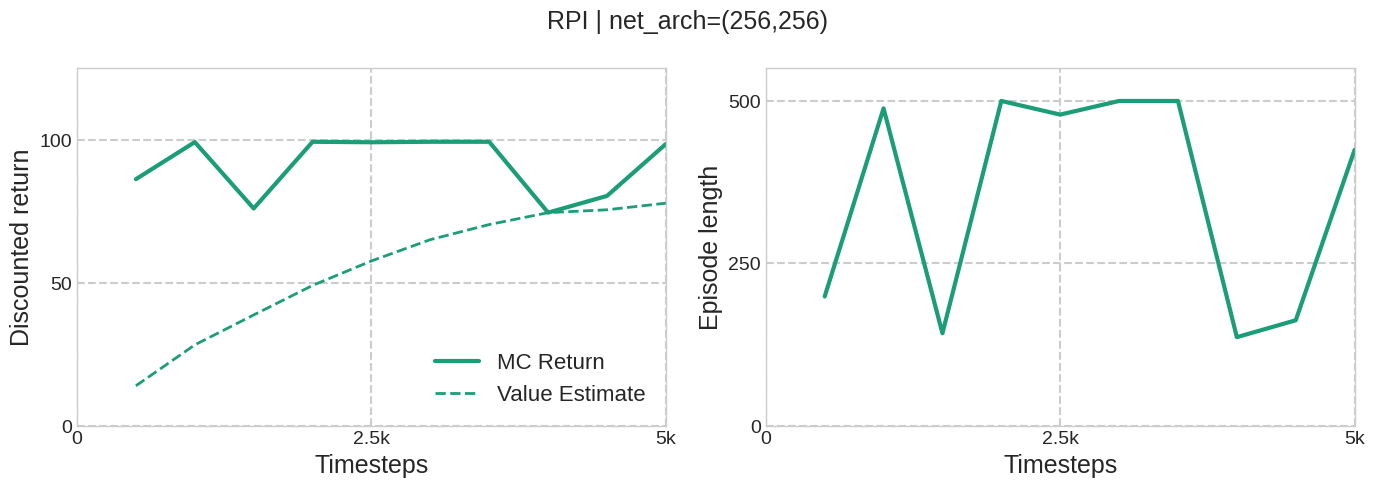

In [ ]:
algo = "RPI"
width = 256
color = ALGO_COLORS[algo]
folder_path = f"./results/net-arch/{algo}/width_{width}_depth_2/seed_0"

true_return = np.load(folder_path + '/mc_disc_returns.npy', allow_pickle=True).mean(axis=1)
est_values  = np.load(folder_path + '/v_s0_estimates.npy', allow_pickle=True).mean(axis=1)
eps_lengths = np.load(folder_path + '/episode_durations.npy', allow_pickle=True).mean(axis=1)
eval_timesteps = np.load(folder_path + '/time_steps_of_eval.npy', allow_pickle=True).mean(axis=1)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

# ---------------- Left plot: Return vs Value ----------------
ax = axes[0]
ax.plot(eval_timesteps, true_return,
        color=color, linestyle='-', linewidth=3, label=f'MC Return')
ax.plot(eval_timesteps, est_values,
        color=color, linestyle='--', linewidth=2, label=f'Value Estimate')


ax.set_ylim(0, 125)
ax.set_xlim(0, 50000)
ax.set_xticks([0, 25000, 50000])
ax.set_xticklabels(['0', '2.5k', '5k'])
ax.set_yticks([0, 50, 100])
ax.set_ylabel("Discounted return")
ax.set_xlabel("Timesteps")
ax.grid(True, which='both', linestyle='--', linewidth=1.5)
ax.legend()

# ---------------- Right plot: Episode length ----------------
ax = axes[1]
ax.plot(eval_timesteps, eps_lengths,
        color=color, linestyle='-', linewidth=3, label=f'{algo}')

ax.set_ylim(0, 550)
ax.set_xlim(0, 50000)
ax.set_xticks([0, 25000, 50000])
ax.set_xticklabels(['0', '2.5k', '5k'])
ax.set_yticks([0, 250, 500])
ax.set_ylabel("Episode length")
ax.set_xlabel("Timesteps")
ax.grid(True, which='both', linestyle='--', linewidth=1.5)


fig.suptitle(f"{algo} | net_arch=({width},{width})", fontsize=18)
plt.tight_layout()
plt.show()


# RPI on Cartpole - 2 layers of 8 neurons each

In [ ]:
# RPI with 8 neurons

############
# Training #
############

c = 1.0
lambda1 = 10.0
lambda2 = 2.0
r_min = 1.0

folder_path = "./results/net-arch/RPI/width_8_depth_2/seed_0"
model = RPI_DQN(env=env, my_c=c, my_lambda1=lambda1, my_lambda2=lambda2, my_r_min=r_min, **hyperparams8)


# Setup evaluation callback
eval_callback = EvalWithCriticCallback(
    eval_env=eval_env,
    eval_freq=eval_freq,
    n_eval_episodes=n_eval_episodes,
    save_path=folder_path,
    algo="RPI",
    verbose=1,
    gamma=hyperparams['gamma']
)
callback_list = eval_callback
# Train the model
print("Starting training...")
tic = time.time()
model.learn(total_timesteps=n_timesteps, callback=callback_list)
toc = time.time()
print(f"\nTraining complete!\nTime taken to run: {datetime.timedelta(seconds=int(toc-tic))}\nResults saved to: {folder_path}")

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/utils.py:195: UserWarning: get_linear_fn() is deprecated, please use LinearSchedule() instead
  warnings.warn("get_linear_fn() is deprecated, please use LinearSchedule() instead")


Starting training...
Eval num_timesteps=5000, episode_reward=39.60 +/- 4.22
Episode length: 39.60 +/- 4.22
New best mean reward!
[Eval] Timesteps: 5000 Avg Disc Return: 31.63, Avg V(s_0): 11.9882
Eval num_timesteps=10000, episode_reward=125.80 +/- 5.71
Episode length: 125.80 +/- 5.71
New best mean reward!
[Eval] Timesteps: 10000 Avg Disc Return: 70.86, Avg V(s_0): 21.6131
Eval num_timesteps=15000, episode_reward=135.00 +/- 3.79
Episode length: 135.00 +/- 3.79
New best mean reward!
[Eval] Timesteps: 15000 Avg Disc Return: 74.95, Avg V(s_0): 24.8067
Eval num_timesteps=20000, episode_reward=141.00 +/- 3.52
Episode length: 141.00 +/- 3.52
New best mean reward!
[Eval] Timesteps: 20000 Avg Disc Return: 77.02, Avg V(s_0): 28.1015
Eval num_timesteps=25000, episode_reward=157.60 +/- 3.72
Episode length: 157.60 +/- 3.72
New best mean reward!
[Eval] Timesteps: 25000 Avg Disc Return: 78.14, Avg V(s_0): 36.8932
Eval num_timesteps=30000, episode_reward=137.00 +/- 3.74
Episode length: 137.00 +/- 3.74

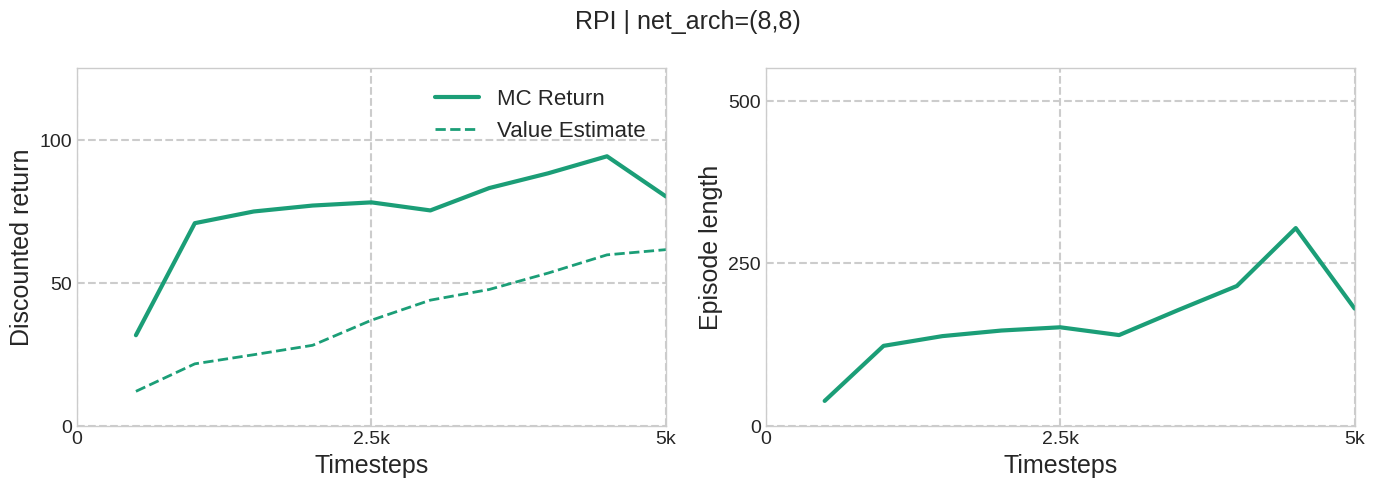

In [ ]:
algo = "RPI"
width = 8
color = ALGO_COLORS[algo]
folder_path = f"./results/net-arch/{algo}/width_{width}_depth_2/seed_0"

true_return = np.load(folder_path + '/mc_disc_returns.npy', allow_pickle=True).mean(axis=1)
est_values  = np.load(folder_path + '/v_s0_estimates.npy', allow_pickle=True).mean(axis=1)
eps_lengths = np.load(folder_path + '/episode_durations.npy', allow_pickle=True).mean(axis=1)
eval_timesteps = np.load(folder_path + '/time_steps_of_eval.npy', allow_pickle=True).mean(axis=1)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

# ---------------- Left plot: Return vs Value ----------------
ax = axes[0]
ax.plot(eval_timesteps, true_return,
        color=color, linestyle='-', linewidth=3, label=f'MC Return')
ax.plot(eval_timesteps, est_values,
        color=color, linestyle='--', linewidth=2, label=f'Value Estimate')


ax.set_ylim(0, 125)
ax.set_xlim(0, 50000)
ax.set_xticks([0, 25000, 50000])
ax.set_xticklabels(['0', '2.5k', '5k'])
ax.set_yticks([0, 50, 100])
ax.set_ylabel("Discounted return")
ax.set_xlabel("Timesteps")
ax.grid(True, which='both', linestyle='--', linewidth=1.5)
ax.legend()

# ---------------- Right plot: Episode length ----------------
ax = axes[1]
ax.plot(eval_timesteps, eps_lengths,
        color=color, linestyle='-', linewidth=3, label=f'{algo}')

ax.set_ylim(0, 550)
ax.set_xlim(0, 50000)
ax.set_xticks([0, 25000, 50000])
ax.set_xticklabels(['0', '2.5k', '5k'])
ax.set_yticks([0, 250, 500])
ax.set_ylabel("Episode length")
ax.set_xlabel("Timesteps")
ax.grid(True, which='both', linestyle='--', linewidth=1.5)


fig.suptitle(f"{algo} | net_arch=({width},{width})", fontsize=18)
plt.tight_layout()
plt.show()


# Comparison Plots

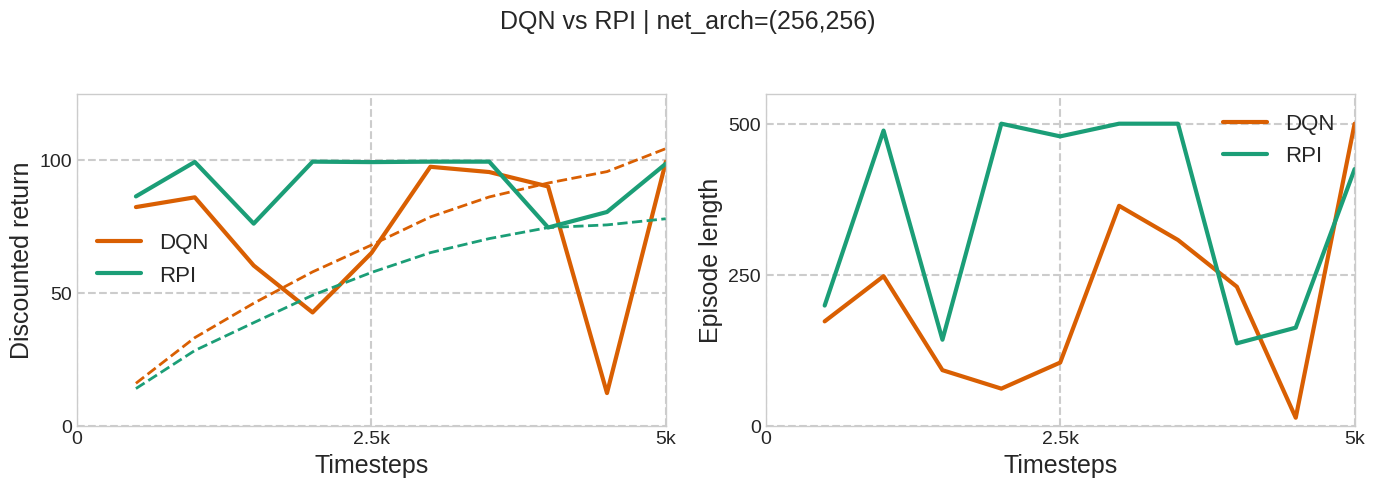

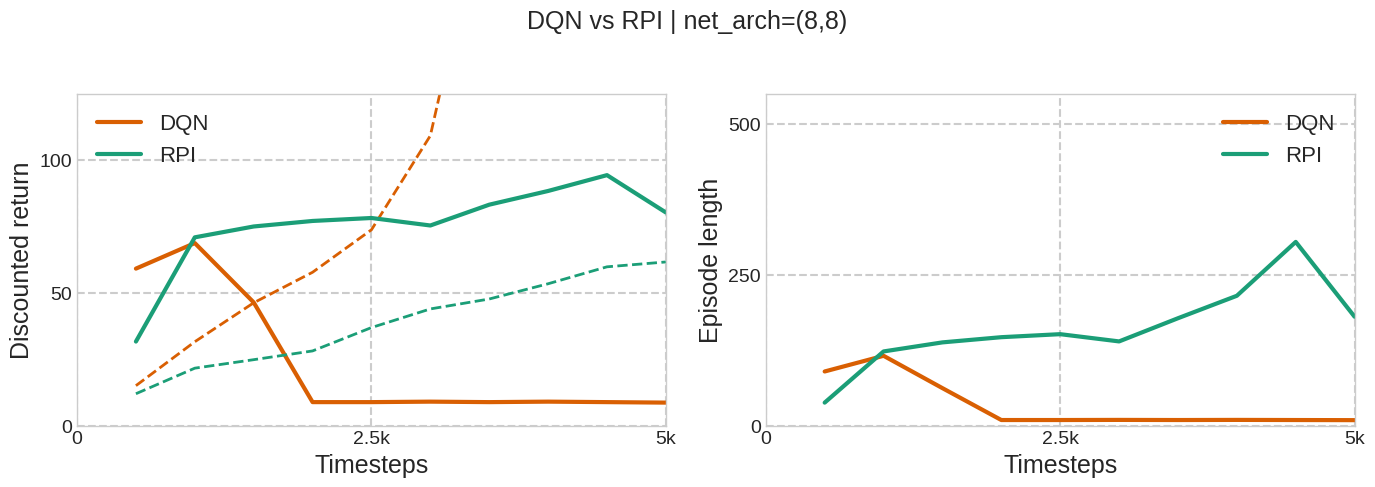

In [ ]:
algos = ["DQN", "RPI"]

for width in [256, 8]:
    folders = {
        "DQN": f"./results/net-arch/DQN/width_{width}_depth_2/seed_0",
        "RPI": f"./results/net-arch/RPI/width_{width}_depth_2/seed_0",
    }

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

    for algo in algos:
        color = ALGO_COLORS[algo]
        folder_path = folders[algo]

        true_return = np.load(folder_path + '/mc_disc_returns.npy', allow_pickle=True).mean(axis=1)
        est_values  = np.load(folder_path + '/v_s0_estimates.npy', allow_pickle=True).mean(axis=1)
        eps_lengths = np.load(folder_path + '/episode_durations.npy', allow_pickle=True).mean(axis=1)
        eval_timesteps = np.load(folder_path + '/time_steps_of_eval.npy', allow_pickle=True).mean(axis=1)

        # ---------------- Left plot: Return vs Value ----------------
        axes[0].plot(
            eval_timesteps, true_return,
            color=color, linestyle='-', linewidth=3,
            label=f'{algo}'
        )
        axes[0].plot(
            eval_timesteps, est_values,
            color=color, linestyle='--', linewidth=2
        )

        # ---------------- Right plot: Episode length ----------------
        axes[1].plot(
            eval_timesteps, eps_lengths,
            color=color, linestyle='-', linewidth=3,
            label=f'{algo}'
        )

    # ---------------- Formatting: Left ----------------
    ax = axes[0]
    ax.set_ylim(0, 125)
    ax.set_xlim(0, 50000)
    ax.set_xticks([0, 25000, 50000])
    ax.set_xticklabels(['0', '2.5k', '5k'])
    ax.set_yticks([0, 50, 100])
    ax.set_ylabel("Discounted return")
    ax.set_xlabel("Timesteps")
    ax.grid(True, which='both', linestyle='--', linewidth=1.5)
    ax.legend()

    # ---------------- Formatting: Right ----------------
    ax = axes[1]
    ax.set_ylim(0, 550)
    ax.set_xlim(0, 50000)
    ax.set_xticks([0, 25000, 50000])
    ax.set_xticklabels(['0', '2.5k', '5k'])
    ax.set_yticks([0, 250, 500])
    ax.set_ylabel("Episode length")
    ax.set_xlabel("Timesteps")
    ax.grid(True, which='both', linestyle='--', linewidth=1.5)
    ax.legend()

    # ---------------- Figure title ----------------
    fig.suptitle(
        f"DQN vs RPI | net_arch=({width},{width})",
        fontsize=18
    )

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# Hopper-v5 trained on our algorithm (CRPI)


## Before training

In [ ]:
from IPython.display import HTML

FILE_ID = "1qeHD4IYVVhVW5kKKnGUivNdgaaD3V1bW"

HTML(f"""
<iframe src="https://drive.google.com/file/d/{FILE_ID}/preview"
        width="640" height="480"
        allow="autoplay">
</iframe>
""")

## After training

In [ ]:
FILE_ID = "1tRrZ0RgrS2kCLCjgbUFXpcYPK-Efjmtk"

HTML(f"""
<iframe src="https://drive.google.com/file/d/{FILE_ID}/preview"
        width="640" height="480"
        allow="autoplay">
</iframe>
""")